In [19]:
import pandas as pd
import torch
import numpy as np

1. Read in csv just generated
2. Build data loader out of dataset
3. write function to train an epoch on this dataset
4. write a function to train for 100 epochs on this dataset
5. apply svcca on this
6. visualize the svcca scores

In [97]:
output_name = "model_one"

data = pd.read_csv("result.csv")
x = torch.tensor(data['X1'].values).float()
y = torch.tensor(data.drop('X1', axis = 1).values).float()
train_ix = np.random.choice(len(x), int(0.8 * len(x)))

In [98]:
def initialize_model(n_inputs=1, n_outputs=5, H = 200):
    return torch.nn.Sequential(
        torch.nn.Linear(n_inputs, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, n_outputs),
    )

def write_activations(model, x, output_name, ix=[1, 3, 5, 7]):
    h = activations(model, x, [1, 3, 5, 7])
    for i in range(len(h)):
        pd.DataFrame(h[i]).to_csv(f"activations_{output_name}_{i}.csv", index = False)
        
def activations(model, x, ix):
    hs = []
    for i in ix:
        x_ = x[:, np.newaxis]
        h_i = model[:i](x_).detach().numpy()
        hs.append(np.concatenate((x_, h_i), axis=1))

    return hs

In [111]:
loss_fn = torch.nn.MSELoss()
model = initialize_model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
losses = {"train": [], "test": []}
y_hats = []

for epoch in range(1200):
    # get loss
    optimizer.zero_grad()
    y_hat = model(x[train_ix, np.newaxis])
    loss = loss_fn(y[train_ix], y_hat)
    
    # update weights
    loss.backward()
    optimizer.step()
    
    if  epoch % 50 == 0:
        torch.save(model.state_dict(), f"{output_name}_{epoch}.pt")

    
    # validation
    with torch.no_grad():
        y_hat = model(x[-train_ix, np.newaxis])
        loss_ = loss_fn(y[-train_ix], y_hat)
        losses["train"].append(loss.detach().numpy())
        losses["test"].append(loss_.detach().numpy())
        y_hats.append(model(x[:, np.newaxis]).detach().numpy())

torch.save(model.state_dict(), f"{output_name}_final.pt")

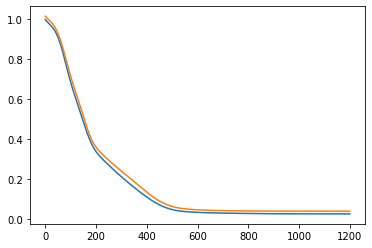

In [114]:
import matplotlib.pyplot as plt
plt.plot(losses["train"])
plt.plot(losses["test"])

In [116]:
# saving some data just to make the gif

y_hats = np.stack(y_hats)
y_hat_df = []
for i in range(1200):
    for j in range(5):
        for k in range(201):
            y_hat_df.append({
                "k": k,
                "epoch": i,
                "x": x[k].item(),
                "f": j,
                "y": y[k, j].item(),
                "y_hat": y_hats[i, k, j]
            })
        
y_hat_df = pd.DataFrame(y_hat_df)
y_hat_df.to_csv(f"{output_name}_y_hats.csv")

In [120]:
state_dict = torch.load(f"{output_name}_final.pt", map_location="cpu")
model = initialize_model()
model.load_state_dict(state_dict)

<All keys matched successfully>

In [121]:
write_activations(model, x, output_name)

for i in range(0, 1200, 50):
    state_dict = torch.load(f"{output_name}_{i}.pt", map_location="cpu")
    model = initialize_model()
    model.load_state_dict(state_dict)
    write_activations(model, x, f"{output_name}_{i}")